<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/04-01-2020.csv"

#https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/
#csse_covid_19_data/csse_covid_19_daily_reports/04-01-2020.csv
dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [43]:
us_pop = 329968629  #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US affecte: {(res.positive+res.death)/us_pop*100:2f}%")

positive     239009
negative    1028649
pending       62119
death          5784
total       1329777
dtype: int64
Current Infection Rate 17.973615%
Percentage of US affecte: 0.074187%


In [44]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative
37,NY,92381,146584
34,NJ,25590,33520
24,MI,10791,11893
5,CA,9191,23809
20,LA,9150,41936
21,MA,8966,47642
10,FL,8010,69286
16,IL,7695,35961
41,PA,7016,47698
52,WA,5984,68814


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA.positive.sum().reset_index().copy()
dfCAPos = gbCA.positive.sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [46]:
dfUSAPos[-7:]

,date,positive,PCT
23,2020-03-27,99413,0.415938
24,2020-03-28,118234,0.494684
25,2020-03-29,139061,0.581823
26,2020-03-30,160530,0.671648
27,2020-03-31,184770,0.773067
28,2020-04-01,210770,0.881850
29,2020-04-02,239009,1.000000


In [47]:
dfCAPos[-7:]

,date,positive,PCT
23,2020-03-27,3879,0.422043
24,2020-03-28,4643,0.505168
25,2020-03-29,5708,0.621042
26,2020-03-30,6447,0.701447
27,2020-03-31,7482,0.814057
28,2020-04-01,8155,0.887281
29,2020-04-02,9191,1.000000


In [48]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-03-29,139061,692290,65549,9922.0,19730.0,2456.0,2642.0,59.0,440.0,4061.0,2428,19730.0,896900,831351,831351,463.0,3001.0,74820.0,20827.0,95647.0
2020-03-30,160530,784324,65382,12147.0,22303.0,2982.0,3177.0,259.0,644.0,4560.0,2939,22303.0,1010236,944854,944854,511.0,2573.0,92034.0,21469.0,113503.0
2020-03-31,184770,864201,59529,14236.0,26660.0,3402.0,3644.0,69.0,507.0,5666.0,3746,26660.0,1108500,1048971,1048971,807.0,4357.0,79877.0,24240.0,104117.0
2020-04-01,210770,939190,59687,16223.0,31142.0,3837.0,4270.0,71.0,676.0,7084.0,4700,31142.0,1209647,1149960,1149960,954.0,4482.0,74989.0,26000.0,100989.0
2020-04-02,239009,1028649,62119,17176.0,32630.0,4264.0,541.0,67.0,661.0,8586.0,5784,32630.0,1329777,1267658,1267658,1084.0,4334.0,89459.0,28239.0,117698.0


In [49]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-03-29,5708,20549,64400,1034.0,1034.0,410.0,410.0,0.0,0.0,0.0,123,1034.0,90657,26257,26257,22.0,0.0,0.0,1065.0,1065.0
2020-03-30,6447,20549,64400,1432.0,1432.0,597.0,597.0,0.0,0.0,0.0,133,1432.0,91396,26996,26996,10.0,398.0,0.0,739.0,739.0
2020-03-31,7482,21772,57400,1617.0,1617.0,657.0,657.0,0.0,0.0,0.0,153,1617.0,86654,29254,29254,20.0,185.0,1223.0,1035.0,2258.0
2020-04-01,8155,21772,57400,1855.0,1855.0,774.0,774.0,0.0,0.0,0.0,171,1855.0,87327,29927,29927,18.0,238.0,0.0,673.0,673.0
2020-04-02,9191,23809,59500,1922.0,0.0,816.0,0.0,0.0,0.0,0.0,203,0.0,92500,33000,33000,32.0,0.0,2037.0,1036.0,3073.0


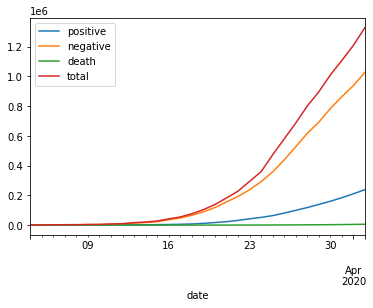

In [50]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [51]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
20200320,10442,150
20200321,15219,201
20200322,15219,201
20200323,31573,402
20200324,42164,471
20200325,51914,673
20200326,63570,884
20200327,68334,991
20200328,85228,1243


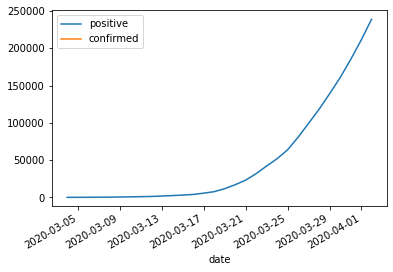

In [52]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [53]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-03-27,3879,17380,57400,746.0,746.0,200.0,200.0,0.0,0.0,0.0,78,746.0,78659,21259,21259,13.0,746.0,0.0,873.0,873.0
2020-03-28,4643,20549,64400,1034.0,1034.0,410.0,410.0,0.0,0.0,0.0,101,1034.0,89592,25192,25192,23.0,288.0,3169.0,764.0,3933.0
2020-03-29,5708,20549,64400,1034.0,1034.0,410.0,410.0,0.0,0.0,0.0,123,1034.0,90657,26257,26257,22.0,0.0,0.0,1065.0,1065.0
2020-03-30,6447,20549,64400,1432.0,1432.0,597.0,597.0,0.0,0.0,0.0,133,1432.0,91396,26996,26996,10.0,398.0,0.0,739.0,739.0
2020-03-31,7482,21772,57400,1617.0,1617.0,657.0,657.0,0.0,0.0,0.0,153,1617.0,86654,29254,29254,20.0,185.0,1223.0,1035.0,2258.0
2020-04-01,8155,21772,57400,1855.0,1855.0,774.0,774.0,0.0,0.0,0.0,171,1855.0,87327,29927,29927,18.0,238.0,0.0,673.0,673.0
2020-04-02,9191,23809,59500,1922.0,0.0,816.0,0.0,0.0,0.0,0.0,203,0.0,92500,33000,33000,32.0,0.0,2037.0,1036.0,3073.0


In [54]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    213372
dead           4757
dtype: int64

In [55]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    9399
dead          199
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [57]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                213372
Italy             110574
Spain             104118
China              82361
Germany            77872
France             57749
Iran               47593
United Kingdom     29865
Switzerland        17768
Turkey             15679
Name: confirmed, dtype: int64

In [58]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(20)

country
US                213372
Italy             110574
Spain             104118
China              82361
Germany            77872
France             57749
Iran               47593
United Kingdom     29865
Switzerland        17768
Turkey             15679
Belgium            13964
Netherlands        13696
Austria            10711
Korea, South        9887
Canada              9560
Portugal            8251
Brazil              6836
Israel              6092
Sweden              4947
Norway              4863
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [63]:
dfState.loc['FL'].head(7)

,date,positive,current_total,pct
state,,,,
FL,2020-04-02,8010,8010,1.000000
FL,2020-04-01,6955,8010,0.868290
FL,2020-03-31,6338,8010,0.791261
FL,2020-03-30,5473,8010,0.683271
FL,2020-03-29,4246,8010,0.530087
FL,2020-03-28,3763,8010,0.469788
FL,2020-03-27,2765,8010,0.345194


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

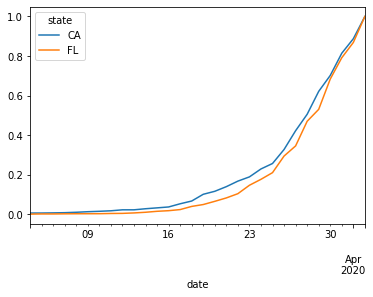

In [65]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

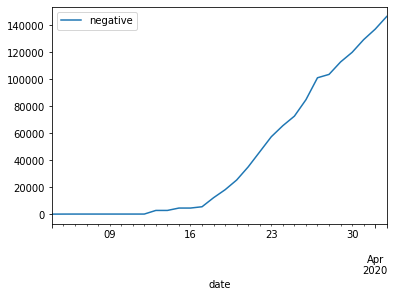

In [67]:
x = dfNYTesting.plot.line()

In [68]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,current_total,pct
274,FL,2020-04-02,8010,8010,1.000000
275,FL,2020-04-01,6955,8010,0.868290
276,FL,2020-03-31,6338,8010,0.791261
277,FL,2020-03-30,5473,8010,0.683271
278,FL,2020-03-29,4246,8010,0.530087
279,FL,2020-03-28,3763,8010,0.469788
280,FL,2020-03-27,2765,8010,0.345194
281,FL,2020-03-26,2355,8010,0.294007
282,FL,2020-03-25,1682,8010,0.209988
283,FL,2020-03-24,1412,8010,0.176280


In [76]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=3)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .60)].sort_values(by='positive',ascending=False)


,state,date,positive,current_total,pct
1138,PA,2020-03-30,4087,7016,0.582526
551,LA,2020-03-30,4025,9150,0.439891
307,GA,2020-03-30,2809,5348,0.525243
467,IN,2020-03-30,1786,3039,0.587693
721,MO,2020-03-30,1031,1834,0.562159
1354,VA,2020-03-30,1020,1706,0.597890
1211,SC,2020-03-30,925,1554,0.595238
1081,OK,2020-03-30,481,879,0.547213
410,ID,2020-03-30,310,669,0.463378
1166,PR,2020-03-30,174,316,0.550633


In [75]:
datecutoff

Timestamp('2020-03-30 00:00:00')

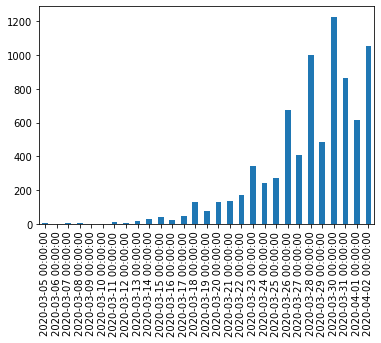

In [72]:
state = 'FL'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar()



# State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfStateData = pd.read_csv(data_url)

In [36]:
dfStateData[dfStateData.STATE >0][['STATE','NAME', 'POPESTIMATE2019']]

,STATE,NAME,POPESTIMATE2019
5,1,Alabama,4903185
6,2,Alaska,731545
7,4,Arizona,7278717
8,5,Arkansas,3017804
9,6,California,39512223
10,8,Colorado,5758736
11,9,Connecticut,3565287
12,10,Delaware,973764
13,11,District of Columbia,705749
14,12,Florida,21477737


In [37]:
dfStateData[dfStateData.STATE ==0][['STATE','NAME', 'POPESTIMATE2019']]

,STATE,NAME,POPESTIMATE2019
0,0,United States,328239523
1,0,Northeast Region,55982803
2,0,Midwest Region,68329004
3,0,South Region,125580448
4,0,West Region,78347268
